In [2]:
my_solver = "GUROBI"

#from sage.numerical.backends.generic_backend import get_solver as get_solver
from sage.all import *
# !export GRB_LICENSE_FILE=/opt/gurobi912/gurobi.lic
# !export GUROBI_HOME="/opt/gurobi912/linux64"
# !export PATH="$GUROBI_HOME/bin:$PATH"
# !export LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:${GUROBI_HOME}/lib"
from sage_numerical_backends_gurobi.gurobi_backend import GurobiBackend
from sage.numerical.backends.generic_backend import get_solver
#get_solver(solver=GurobiBackend)

In [3]:
!pip install gurobipy

You should consider upgrading via the '/home/storino/SageMath/local/bin/python3 -m pip install --upgrade pip' command.


In [13]:
def linear_arboricity_test(G):
    p = MixedIntegerLinearProgram(maximization=True,solver=my_solver)
    
#    variável da aresta: x[e,c]=1 implica que a aresta e é colorida pela cor c
    x = p.new_variable(binary=True)
    
    Delta = max(G.degree())
    
    colors = range(ceil((Delta+1)/2))
    
#    cada aresta recebe exatamente uma cor
    for e in G.edges():
        equation=0
        for c in colors:
            equation+=x[e,c]
        p.add_constraint(equation==1)
        
#    o grau da cor c de cada vertice deve ser menor ou igual a 2
    for u in G.vertices():
        for c in colors:
            equation=0
            for e in G.edges_incident(u):
                equation+=x[e,c]
            p.add_constraint(equation<=2)
    
    sol=p.solve()
    solution=p.get_values(x).items()
    R=[]
    for s in solution:
        var, val = s
        e,c = var
        if val==1 and c == 0:
            R.append(e)
    H=Graph(R)
    H.show()
        
    return p,x

In [5]:
G = graphs.RandomGNP(10,.5)

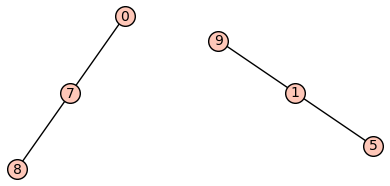

39 13


In [6]:
p,x=linear_arboricity(G)
print(p.number_of_variables(), G.size())

In [2]:
#!/bin/env sage
# -*- coding: utf-8 -*-
import gurobipy as gp
from gurobipy import GRB

def mycallback(model, where):
    """
    This function checks whether the incumbent solution found by Gurobi has a
    cycle or not. If a cycle was found, then this function adds a constraint
    that is violated by the current solution.

    To be more precise, if a cycle C is found in the current solution,
    then this function adds the following constraint

      ∑ x_{e, 0} ≤ |E(C)| - 1
    e ∈ E(C)
    """

    if where == GRB.Callback.MIPSOL:

        vals = model.cbGetSolution(model._x)
        
        G = Graph()
        for (pair, val) in vals.items():
            e,c = pair
            if val > 0:
                u,v,label=e
                G.add_edge((u,v,c))
        
        #G.show(color_by_label=True,layout="circular")
        
        Delta = max(G.degree())
#         colors = range(ceil((Delta+1)/2)+1) 
        colors = model._colors
        
        dic = {}
        
        for c in colors:
            dic[c] = []
        
        for e in G.edges():
            u,v,color = e
            dic[color].append(e)

        cycles = []
        for c in colors:
            H = Graph(dic[c])
            components = H.connected_components()
            for comp in components:
                comp_graph = H.subgraph(comp)
                is_forest, cycle = comp_graph.is_forest(certificate=True)
                if not is_forest:
                    csize = len(cycle)
                    cycle.append(cycle[0])
                    cycle_edges=[]
                    for i in range(csize):
                        u=cycle[i]
                        v=cycle[i+1]
                        if u < v:
                            cycle_edges.append((u,v))
                        else:
                            cycle_edges.append((v,u))
                    cycles.append(cycle_edges)
                    
        for cycle_edges in cycles:
            csize = len(cycle_edges)
            for c in colors:
                expr = 0
                for u,v in cycle_edges:
                    expr += model._x[((u,v,None),c)]
                model.cbLazy(expr <= csize - 1)
            #print("restriction added on cycle",cycle_edges)
        
class Model:

    def __init__(self, G):

        self.model = gp.Model("linear arboricity")
        self.model.setParam('OutputFlag', 0)
        self.G = G
        self.Delta = max(G.degree())
        self.colors = range(ceil((self.Delta+1)/2))

        self._init_x_variables()

        # The next lines are defining some variables inside the model object so
        # that they can be accessed in the callback (yeah.. I'm breaking
        # encapsulation).  That's not very pretty, but it's the way it's
        # suggested by the Gurubi Another solution would be to define global
        # variables.
        
        self.model._x = self.x
        self.model._G = self.G
        self.model._colors = self.colors

        self._add_constr_vertex_color_degree()
        self._add_constr_edge_color()

    def _init_x_variables(self):
        """
              ⎧1,  if e ∈ E(G) is selected
        x_e = ⎨
              ⎩0,  otherwise
        """
        indices = [(e,c) for e in self.G.edges() for c in self.colors]
        #print(indices)
        self.x = self.model.addVars(indices, lb=0.0, ub=1.0, vtype=GRB.BINARY, name="x")

    def _add_constr_vertex_color_degree(self):
        """
        Every vertex has degree at most 2 in each color, and 0 has degree precisely 1

        """
            
        for u in self.G.vertices():
            for c in self.colors:
                equation=0
                for e in self.G.edges_incident(u):
                    equation+=self.x[e,c]
                self.model.addConstr(equation<=2, name="color degree")

    def _add_constr_edge_color(self):
        """
        Some edge have to repeat once, and some edge do not repeat

        """
        
        for e in self.G.edges():
            equation=0
            for c in self.colors:
                equation+=self.x[e,c]
            self.model.addConstr(equation==1, name="each edge")

    def solve(self):

        self.model.write("modelo_debug.lp")

        # ⚠ if you plan to use lazyConstraints in Gurobi,
        #     you must set the following parameter to 1
        self.model.Params.lazyConstraints = 1

        # to use an lazyConstraint `foo`, you must pass it
        # as a parameter in the function optimize
        self.model.optimize(mycallback)
        
    def color(self):
        if self.model.status != GRB.OPTIMAL:
            print(self.model.status, GRB.OPTIMAL)
            print("diferente do ótimo", self.G.graph6_string())
            return []

        #print(self.x)
        for e in self.G.edges():
            for c in self.colors:
                if self.x[e,c].x >0.1:
                    self.G.set_edge_label(e[0],e[1],c)
                    
    def uncolor(self):
        for e in self.G.edges():
            self.G.set_edge_label(e[0],e[1],None)
                    
    def color_graphs(self):
        
        dic = {}
        
        for c in self.colors:
            dic[c] = []
        
        for e in self.G.edges():
            u,v,color = e
            dic[color].append(e)

        graphs=[]
        for c in self.colors:
            H = Graph(dic[c])
            graphs.append(H)
            
        return graphs

    def show(self):

        self.color()
        
        self.G.show(color_by_label=True,layout="circular")

In [63]:
%%timeit

def test(n,p):
    G=graphs.RandomGNP(n,p)
    M=Model(G)
    M.solve()

test(10,.5)

The slowest run took 9.72 times longer than the fastest. This could mean that an intermediate result is being cached.
147 ms ± 90.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


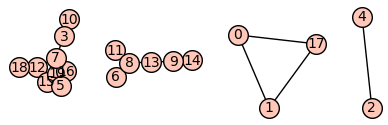

[[3, 5, 7, 10, 12, 15, 16, 18, 19], [6, 8, 9, 11, 13, 14], [0, 1, 17], [2, 4]] 4


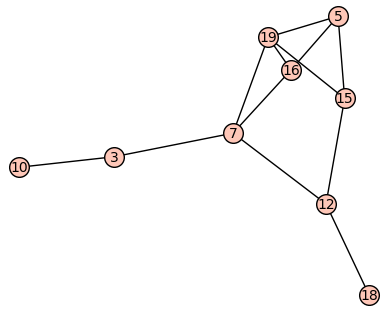

In [23]:
G = graphs.RandomGNP(20,.1)
G.show()
components = G.connected_components()
print(components, len(components))
H = G.subgraph(components[0])
H.show()

In [5]:
from sage.graphs.graph_coloring import linear_arboricity


In [13]:
%%timeit

#nosso LA

o = open("benchmark3.g6")

for x in o:
    G = Graph(x)
    M = Model(G)
    M.solve()

12min 2s ± 1min 11s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit 

#LA do sage 

o = open("benchmark3.g6")

for x in o:
    G = Graph(x)
    linear_arboricity(G, solver="GUROBI")

9min 27s ± 20.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit 

#LA do sage GLPK

o = open("benchmark2.g6")

for x in o:
    G = Graph(x)
    linear_arboricity(G, solver="GLPK")

KeyboardInterrupt: 

In [82]:
#benchmark

o = open("benchmark.g6", 'w')

for n in [8,10,12,14]:
    for r in range(6,n-1):
        for i in range(5):
            G = graphs.RandomRegular(r,n)
            o.write(G.graph6_string()+"\n")
o.close()

In [83]:
#benchmark2

o = open("benchmark2.g6", 'w')

for n in [14,16,18,20]:
    for r in range(6,n-1):
        for i in range(5):
            G = graphs.RandomRegular(r,n)
            o.write(G.graph6_string()+"\n")
o.close()

In [61]:
o = open("benchmark.g6")
for x in o:
    print(x)

G~l}~[

G~^m|{

G^vn~w

G~zZ|{

G|~uz{

I^LvU]\rg

IVZv]o^yW

Iy~s[lrMw

Irupm^yZo

Ird~UnhNg

Iv}ni|vzW

IZr~uy~}o

IR~~mnj}W

I]z~np^mw

I~nZ\vN\w

Iny~~~|~g

I~^m|~~~o

I]~~n~}}w

I~^}|~n}w

Iz~u~~}nw

KxO]kXuF\u\I

KbMC~Wk^NFYs

KkbZtDwMoz{k

KFw]JqdnbFWt

KlZM\_tI{{IN

KZvPt}f{I\xr

KlJI~w{tlv\U

KMbvX{|}FTzM

K`{vjZM{]zUy

K[wQ||m~Mj]p

KzYf}y}nqzzl

K|u^mTv~P^nl

K^i]vNlV~{n{

Krjzmv\]|^^R

Kfx~Iyzy~nVy

Knm}^t~|~}\v

K~}}X~vx}vnz

Kv~Zv~fZ~lvv

Km^~~rzztzu~

K}j}p~~^v}~]

K~z~u}~~z~~|

K~]~~^~v~z~z

K~z}|~z~~~N~

Kv|~~^~|~z~z

K^v~~^|~~~^^

MLAJ\PrnCWYhOuUI_

MLOA]YUa^gUiYiNc?

MwoHZhScLcjqE]hw?

MeiarWtcaPgrjcKZ?

M`hZf_q@}ObdotjI?

MZa@hyjv]{HsuBXp_

MQlJtpsxmixcHxcr_

M|NeTWFUIsBvc}X]?

MY]{AsZRuLu`wlkx?

MYa^DiK}I}E|UwYk_

MvG^Wyjrmb{y^Y^R?

Mupr]wv`htvJZ{}F?

MjMbtL}zSyr{uRpm_

M^OZ^Vk}Kyqt\rb|?

MjFIs}~jR[ukyf{f?

M[E~~Jhv^v^IV|^j?

MzlZivNutxs~h}~P_

MLb}rrhl~vn{~`r{_

M]zZjnmE|y}ym]qn_

Myulpz}zRmj}s}lr_

M~|~P^rNu~zmd~x|_

Mvv~nVlhxv~r]}V^_

Ml~~VrNm~mUv\~V~?

M}vsjsnz

In [9]:
#benchmark3

o = open("benchmark3.g6", 'w')

for n in [22,24,26,28]:
    for r in range(6,n-1):
        for i in range(5):
            G = graphs.RandomRegular(r,n)
            o.write(G.graph6_string()+"\n")
o.close()